In [64]:
%matplotlib inline
import cv2 as cv
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction

In [61]:
training_data = [
    {
        'image': 'yolo/images/cropped_img1.png',  
        'mask': 'yolo/images/cropped_mask1.png'
    },
    {
        'image': 'yolo/images/cropped_img2.png',
        'mask': 'yolo/images/cropped_mask2.png'
    }
]

In [59]:
tile_size = 256
overlap = 0.25       
min_barnacles = 3    
# barnacle area
min_area = 100       
max_area = 2000     

In [ ]:
testing_data = [
    'yolo/images/cropped_img1.png',  
    'yolo/images/cropped_img2.png',  
    'yolo/images/cropped_unseen1.png',  
    'yolo/images/rocks4.jpg',  
    'yolo/images/unseen_img2.png'
]

In [48]:
all_tiles = []
step = int(tile_size * (1 - overlap))

for d in training_data: 
    img = cv.imread(d['image'], cv.IMREAD_GRAYSCALE)
    mask = cv.imread(d['mask'], cv.IMREAD_COLOR)    
    h, w = img.shape[:2]

    for y in range(0, h - tile_size + 1, step):
        for x in range(0, w - tile_size + 1, step):
            img_tile = img[y:y+tile_size, x:x+tile_size]
            mask_tile = mask[y:y+tile_size, x:x+tile_size]
            
            th, tw = mask_tile.shape[:2]
            hsv = cv.cvtColor(mask_tile, cv.COLOR_BGR2HSV)
            blue_mask = cv.inRange(hsv, np.array([100, 50, 50]), np.array([130, 255, 255]))
            contours, _ = cv.findContours(blue_mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
            
            labels = []
            for cnt in contours:
                area = cv.contourArea(cnt)
                if area < min_area or area > max_area:
                    continue
                
                bx, by, bw, bh = cv.boundingRect(cnt)
                
                # skip barnacles @ edges
                if bx == 0 or by == 0 or bx + bw >= tw - 1 or by + bh >= th - 1:
                    if bw < 5 or bh < 5:
                        continue
                
                cx = max(0.001, min(0.999, (bx + bw / 2) / tw))
                cy = max(0.001, min(0.999, (by + bh / 2) / th))
                nw = min(bw / tw, 1.0)
                nh = min(bh / th, 1.0)
                labels.append(f"0 {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")
            
            if len(labels) < min_barnacles:
                continue
            
            all_tiles.append((img_tile.copy(), labels))
    

print(f"{len(all_tiles)} tiles")

108 tiles


In [50]:
negs = Path("yolo/negs")
neg_images = [f for f in negs.iterdir()]

for n in neg_images:
    img = cv.imread(str(n))
    h, w = img.shape[:2]
    tile_count = 0
    
    for y in range(0, h - tile_size + 1, step):
        for x in range(0, w - tile_size + 1, step):
            tile = img[y:y+tile_size, x:x+tile_size]
            all_tiles.append((tile.copy(), []))  # empty labels
            tile_count += 1
    
    print(f"{n.name}: {tile_count} tiles")

print(f"all tiles: {len(all_tiles)}")

rocks1.jpg: 2 tiles
coins2.jpg: 20 tiles
coins3.jpg: 8 tiles
all tiles: 168


In [6]:
# random.shuffle(all_tiles)
# n_val = max(1, int(len(all_tiles) * 0.2))
# val_tiles = all_tiles[:n_val]
# train_tiles = all_tiles[n_val:]

# print(f"{len(train_tiles)} train, {len(val_tiles)} val")

output_dir = Path("yolo/barnacle_dataset")
# for split in ["train", "val"]:
#     (output_dir / "images" / split).mkdir(parents=True, exist_ok=True)
#     (output_dir / "labels" / split).mkdir(parents=True, exist_ok=True)

# for split, tiles in [("train", train_tiles), ("val", val_tiles)]:
#     for i, (img, labels) in enumerate(tiles):
#         name = f"{split}_{i:04d}"
#         cv.imwrite(str(output_dir / "images" / split / f"{name}.jpg"), img)
#         with open(output_dir / "labels" / split / f"{name}.txt", "w") as f:
#             f.write("\n".join(labels))

yaml_path = output_dir / "dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(f"""path: {output_dir.absolute()}
train: images/train
val: images/val

names:
  0: barnacle
""")

In [26]:
base_model = "yolov8n.pt"  
project = "yolo/barnacle_training"
run_name = "run"

In [62]:
model = YOLO(base_model)

# results = model.train(
#     data=str(yaml_path),
#     epochs=150,
#     imgsz=256,
#     batch=16,
#     project=project,
#     name=run_name,
#     mosaic=1.0,
#     mixup=0.1,
#     scale=0.5,
#     fliplr=0.5,
#     flipud=0.5,
#     patience=50,
#     save=True,
#     plots=True,
# )

In [51]:
best_weights = Path(project) / run_name / "weights" / "best.pt"
print(best_weights)

yolo/barnacle_training/run/weights/best.pt


In [53]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=str(best_weights),
    confidence_threshold=0.65,
    device='mps',
)

Performing prediction on 56 number of slices.
1490 barnacles
Performing prediction on 64 number of slices.
394 barnacles
Performing prediction on 64 number of slices.
1020 barnacles
Performing prediction on 12 number of slices.
0 barnacles
Performing prediction on 9 number of slices.
123 barnacles


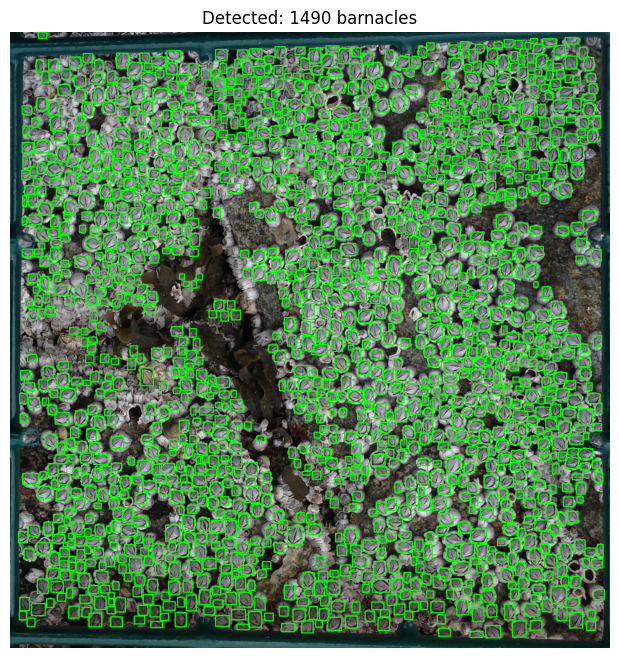

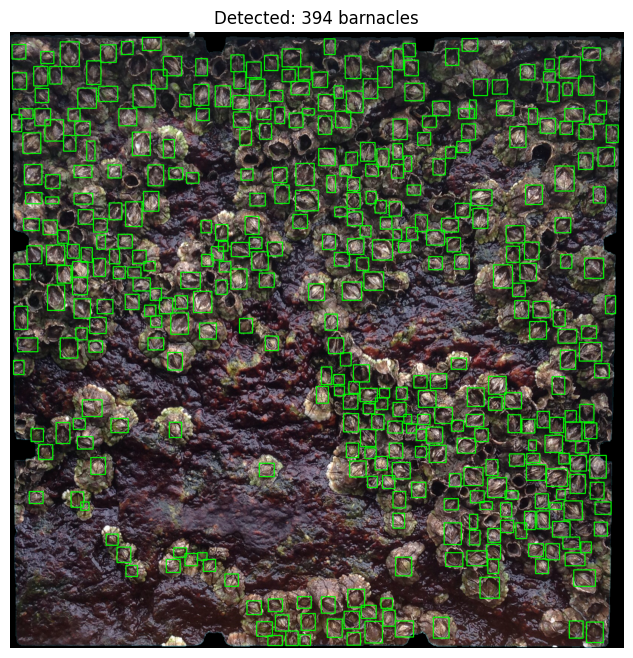

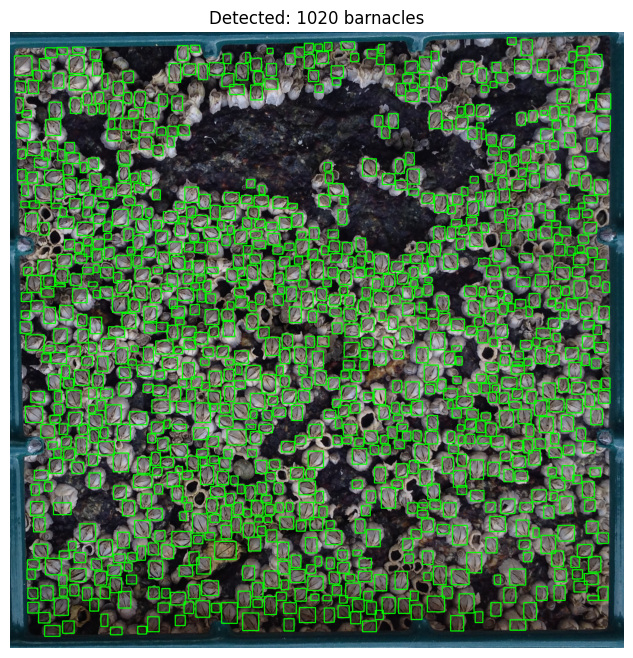

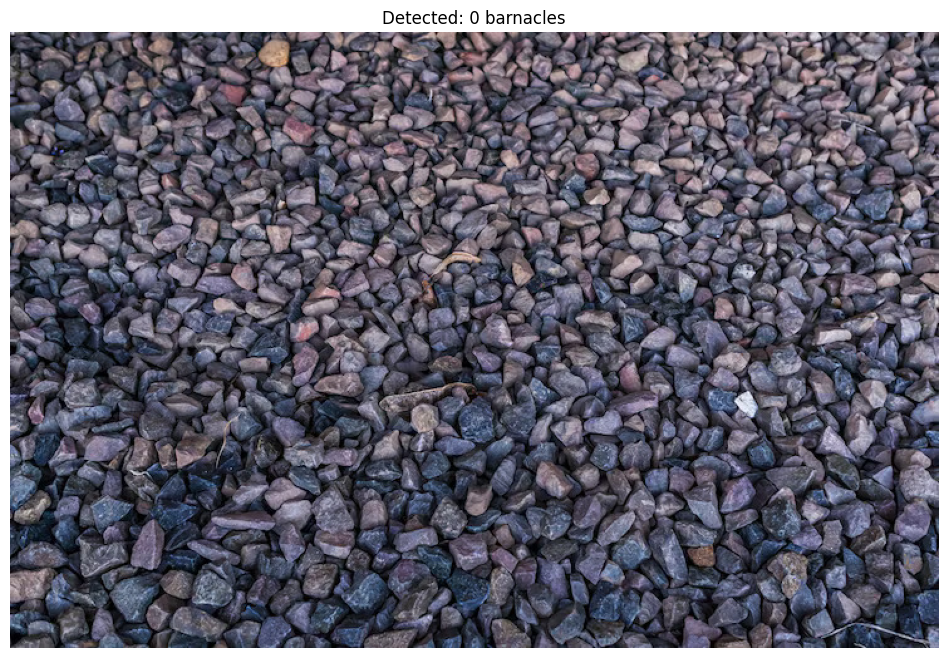

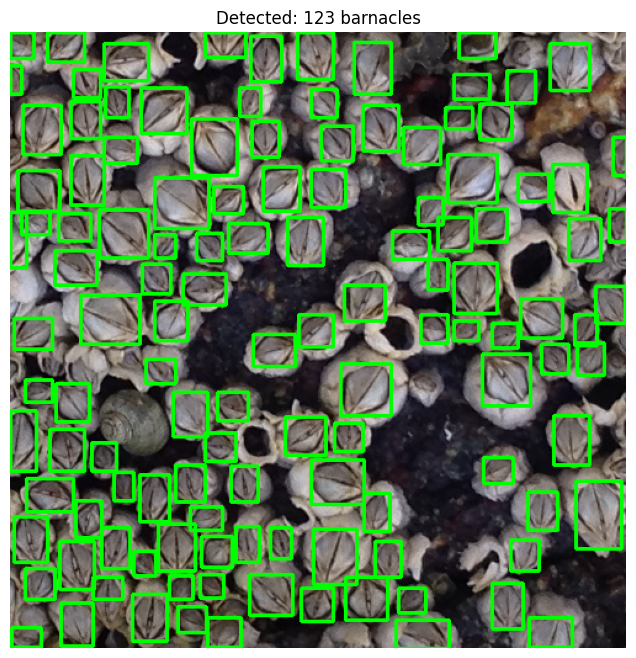

In [66]:
slice_height = 256
slice_width = 256
overlap_ratio = 0.2

for img in testing_data: 
    image = cv.imread(img)
    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    result = get_sliced_prediction(
    img,
    detection_model,
    slice_height=slice_height,
    slice_width=slice_width,
    overlap_height_ratio=overlap_ratio,
    overlap_width_ratio=overlap_ratio,
    perform_standard_pred=True,
    postprocess_type="NMS",
    postprocess_match_metric="IOS",
    postprocess_match_threshold=0.5,
    )

    boxes = []

    for pred in result.object_prediction_list:
        bbox = pred.bbox
        boxes.append([bbox.minx, bbox.miny, bbox.maxx, bbox.maxy])

    boxes = np.array(boxes) if boxes else np.array([]).reshape(0, 4)

    print(f"{len(boxes)} barnacles")


    for b in boxes:
        x1, y1, x2, y2 = map(int, b)
        cv.rectangle(image_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.title(f"Detected: {len(boxes)} barnacles")
    plt.axis("off")

plt.show()